# TP1: Análisis de datos MSAP

**Nota**: Este cuaderno asume que el [TP0](https://colab.research.google.com/github/VeronicaNoe/EpiEvo/blob/main/cuadernos/TP0_espacio_de_trabajo.ipynb) ha sido completado con éxito.


# Contenido

**Objetivo:** Familiarizarse con la identificación de fragmentos diferencialmente metilados utilizando datos MSAP de especies silvestres de papa [Cara et al., 2019](https://nph.onlinelibrary.wiley.com/doi/full/10.1111/nph.15706).



0.   [Preparación de cuaderno](#step-0)
1.   [Preparación del espacio de trabajo en R](#step-1)
2.   [Análisis de datos obtenidos por *MSAP*](#step-2)
  1.   [Análisis exploratorio de los datos](#step-2.1)
  2.   [Selección de alelos polimórficos](#step-2.2)
  3.   [Metilación global](#step-2.3)
  4.   [Comparación de híbridos](#step-2.4)
3.   [OPCIONAL: Guardar en Drive](#step-3)



# Introducción

Analizaremos la metilación del ADN en el híbrido natural *Solanum x rechei* y en las especies parentales *Solanum kurtzianum* y *Solanum microdontum*; y lo compararemos con los híbridos sintéticos obtenidos por cruzamientos controlados.

<p align="left">
<img src="https://raw.githubusercontent.com/VeronicaNoe/EpiEvo/main/img/1/figura.
png" width="800"/> 
</p>




<a name="step-0"></a>
# Preparación del cuaderno

Un opción útil para el resto de los TPs es la posibilidad de contectar un cuaderno con Google Drive.

Los siguientes pasos muestran como realizar dicha conexión:

1. Presionar el botón play, cliquea el enlace mostrado en `Go to this URL in a browser`.
<img src="https://raw.githubusercontent.com/VeronicaNoe/EpiEvo/main/img/00_paso1a.png" width="700"/>

2. Copie el código de autenticación.
<img src="https://raw.githubusercontent.com/VeronicaNoe/EpiEvo/main/img/00_paso1b.png" width="700"/>

3. Ingresar dicho código en el campo `Enter authorization code`.
<img src="https://raw.githubusercontent.com/VeronicaNoe/EpiEvo/main/img/00_paso1c.png" width="700"/>

In [12]:
#@title Solicitar acceso a Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Para trabajar de forma ordenada, se crearán 3 carpetas en colab:
- *rawData*: en donde estarán los archivos necesarios para trabajar (**input**)
- *results*: en donde se guardarán los archivos generados (**output**)
- *plots*: en donde se guardarán los pdf de las figuras (**output**)

In [14]:
#@title Revisar los directorios (desde el navegador de la derecha) 
%%bash
mkdir {rawData,plots,results}
rm -r sample_data/ # eliminarmos la carpeta que está por default en colab
ls

drive
plots
rawData
results


rm: cannot remove 'sample_data/': No such file or directory


En el directorio *rawData* cargaremos los inputs



In [15]:
#@title Cargar archivos
#@title Descargar archivos en el directorio
%%bash
cp -r /content/drive/MyDrive/EpiEvo/epievo_data/1/* /content/rawData
echo 'Debería observar una lista con los archivos commonFunctions.R y MSAP_Genemapper.csv'
ls rawData

Debería observar una lista con los archivos commonFunctions.R y MSAP_Genemapper.csv
commonFunctions.R
MSAP_Genemapper.csv


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<a name="step-1"></a>
# Preparar el espacio de trabajo en R




In [17]:
#@title Cargar R
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [18]:
#@title Instalar librerias
%%R
source(file.path("/content/rawData", "commonFunctions.R"))


R[write to console]: Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/reshape_0.8.8.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 42558 bytes (41 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write

In [ ]:
#@title Establecer el directorio de trabajo
%%R
setwd("/content/results")
getwd()

<a name="step-2"></a>
# Análisis de datos obtenidos por *MSAP*

<a name="step-2.1"></a>
## Análisis exploratorio de los datos

In [ ]:
#@title Abrir la matriz de datos en R
%%R
Data <- read.csv("/content/rawData/MSAP_Genemapper.csv", header = TRUE, row.names = 1, check.names = FALSE)
numHybrids<-nrow(Data)
numLoci<-ncol(Data)
cat("Número de epiLoci=", numLoci,"\n")
cat("Número de muestras=", numHybrids/2 ,"\n")
cat("\n","\t\t\t\t Vista previa de la tabla:", "\n")
Data[1:5,1:10]

Número de epiLoci= 264 
Número de muestras= 15 

 				 Vista previa de la tabla: 
           1Allele 001 1Allele 002 1Allele 003 1Allele 004 1Allele 017
Hybrid_1_h           1           1           0           0           0
Hybrid_1_m           1           1           0           1           0
Hybrid_2_h           1           0           0           0           0
Hybrid_2_m           1           1           0           1           0
Hybrid_3_h           1           1           0           0           0
           1Allele 029 1Allele 030 1Allele 035 1Allele 041 1Allele 042
Hybrid_1_h           0           0           0           0           0
Hybrid_1_m           0           0           1           0           0
Hybrid_2_h           0           1           0           0           0
Hybrid_2_m           0           1           1           0           0
Hybrid_3_h           0           1           0           0           0


Generar la matriz de patrones comparando *_h* (HpaII) y *_m* (MspaI).

<div id="image-table">
    <table>
      <tr>
          <td style="padding:10px">
              <img src="https://raw.githubusercontent.com/VeronicaNoe/EpiEvo/main/TP_01_A.png" width="400"/>
            <td style="padding:10px">
            </td>
        </tr>
    </table>
</div> 

In [1]:
#@title
%%R
MSAP_patterns<- matrix(nrow = dim(Data)[2], ncol = 0)
out<- c()
for (hyb in 1:numHybrids) if (hyb %% 2 ==1){
  for (loci in 1:numLoci){
    out<- append(out, ifelse(Data[hyb,loci]+Data[hyb+1,loci]==0,'0', # en este caso, suma los valores de las fila j y j+1 en la fila i
                      # si el test es falso, continua con la siguiente línea que es otro test
                      ifelse(Data[hyb,loci]+Data[hyb+1,loci]==2,'1',
                      # si el test es falso, termina con el 3
                      ifelse(Data[hyb,loci]==1,'2','3'))))
  }
  MSAP_patterns<-cbind(MSAP_patterns,matrix(out,dimnames = list(colnames(Data),substr(row.names(Data)[hyb],1,nchar(as.character(row.names(Data)[hyb]))-2))))
  out<- c()
}
cat("Número de epiLoci=", nrow(MSAP_patterns),"\n")
cat("Número de muestras=", ncol(MSAP_patterns),"\n")
cat("\n","\t\t\t\t Vista previa de la tabla:", "\n")
MSAP_patterns[1:5,]
#guardamos
write.csv(t(MSAP_patterns), file = "/content/results/MSAP_patterns.csv")

UsageError: Cell magic `%%R` not found.


<a name="step-2.2"></a>
## Selección de alelos polimórficos
Solo los alelos polimorficos brindan información.

Descartaremos alelos que sean:
- **Singletons**: aquellos que están presentes en una sola muestra.
- **Monomorficos**: aquellos que están presentes en todas las muestras.

<div id="image-table">
    <table>
      <tr>
          <td style="padding:10px">
              <img src="https://raw.githubusercontent.com/VeronicaNoe/EpiEvo/main/TP_01_B.png" width="400"/>
            <td style="padding:10px">
              <img src="https://raw.githubusercontent.com/VeronicaNoe/EpiEvo/main/TP_01_C.png" width="400"/>
            </td>
        </tr>
    </table>
</div> 

In [ ]:
#@ title Generamos las variables dummy para cada patrón.
%%R
dummies<- matrix(nrow = ncol(MSAP_patterns), ncol = 0)

for (loci in 1:numLoci){
  dummies <- cbind(dummies,
          matrix(as.numeric(MSAP_patterns[loci,] == 1), dimnames = list(colnames(MSAP_patterns), paste(row.names(MSAP_patterns)[loci],"1",sep = "_"))),
          matrix(as.numeric(MSAP_patterns[loci,] == 2), dimnames = list(colnames(MSAP_patterns), paste(row.names(MSAP_patterns)[loci],"2",sep = "_"))),
          matrix(as.numeric(MSAP_patterns[loci,] == 3), dimnames = list(colnames(MSAP_patterns), paste(row.names(MSAP_patterns)[loci],"3",sep = "_"))))
}

In [ ]:
#@ title Filtrado y selección de polimórficos
# Por cada alelo, vamos a sumar el número de muestras que presentan el alelo.
%%R
temp<-data.frame(colSums(dummies, dims=1))
colnames(temp)<-c("count")
# Definimos las variables
singletons<-1
monomorphic<-nrow(dummies)
toKeep<-subset(temp, c(count>singletons & count<monomorphic))
toKeep<-rownames(toKeep) #alelos polimorficos
#seleccionamos solo polimorficos de la matriz dummies
binary_matrix<-dummies[,toKeep]
cat("Número de alelos monomorficos =", sum(temp$count==nrow(dummies)), "\n")
cat("Número de alelo singletons =", sum(temp$count==1), "\n")
#cat("Número de alelo nulo =", sum(temp$count<1), "\n")
cat("Número de alelo polimorficos =", dim(binary_matrix)[2], "\n")
cat("Número de alelo totales =", sum(temp$count>=1), "\n")
cat("Número de muestras =", nrow(binary_matrix), "\n")
cat("\n","\t\t\t\t Vista previa de la tabla:", "\n")
binary_matrix[1:5,1:5]
# Guardamos la matriz binaria
write.csv(binary_matrix, file = "/content/results/MSAP_binary_matrix.csv")

Número de alelos monomorficos = 6 
Número de alelo singletons = 82 
Número de alelo polimorficos = 228 
Número de alelo totales = 316 
Número de muestras = 15 

 				 Vista previa de la tabla: 


<a name="step-2.3"></a>
## Metilación global

In [ ]:
#@ title Conteo de alelos metilados y no metilados
%%R
conteoPatrones<-f.count.methylation(binary_matrix)
head(conteoPatrones)
write.csv(conteoPatrones, file = "patrones.csv")
# Calculamos valores medios para cada categoría
summaryPatrones<-f.summary.patrones(conteoPatrones)
write.csv(summaryPatrones, file = "summary_Patrones.csv")

png 
  2 


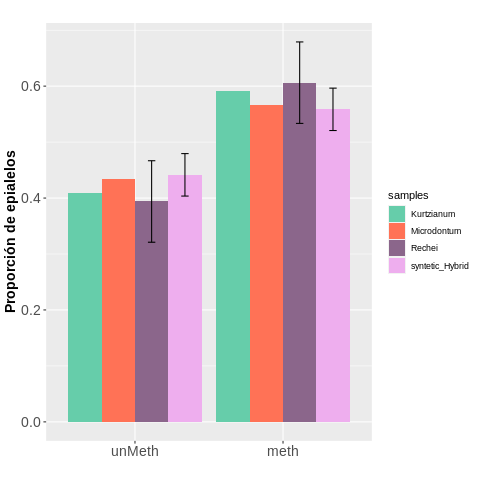

In [ ]:
#@title Gráfico
%%R
p<-ggplot(summaryPatrones,aes(x=variable,y=mean, fill=samples))+ geom_bar(stat="identity", position=position_dodge()) +
geom_errorbar(aes(ymin=mean-sd, ymax=mean+sd), width=.2, position=position_dodge(.9)) +
scale_fill_manual(values=c('aquamarine3', 'coral1', 'plum4', 'plum2')) +
labs(title="", x="", y = "Proporción de epialelos")+ theme(axis.text=element_text(size=14),
        axis.title=element_text(size=14,face="bold"))
plot(p)
pdf("/content/plots/methylation.pdf")
plot(p)
dev.off()

## Comparación de híbridos
Vamos a comparar los híbridos sintéticos con los parentales (*S. kurtzianum* y *S. microdontum*) y los híbridos naturales (*S.* x *rechei*).

Queremos saber cuántos alelos comparte con cada uno.

In [ ]:
#@ title Alelos comunes y únicos en el híbrido sintético
%%R
numAlleles<-ncol(binary_matrix) # Number of alleles
natHyb<-grep("Rechei", rownames(binary_matrix), value = TRUE) # S. x rechei (Natural hybrid)
synHyb<-grep("Hybrid", rownames(binary_matrix), value = TRUE) # Synthetic hybrids

out<- c()
results<- matrix(nrow = 4, ncol = 0)

## This is a double loop for hyb hybrids and allele loci. Rows are as follows: 1-5 Synthetic Hybrids, 6 S. kurtzianum (Parental1),
## 7 S. microdontum (Parental2), 8-15 S.x rechei.
for (hyb in synHyb){
  for (allele in 1:numAlleles)
  {
    out<- append(out, ifelse(binary_matrix[hyb,allele]>0 & binary_matrix['Kurtzianum',allele]>0 & binary_matrix['Microdontum',allele]==0 & sum(binary_matrix[natHyb,allele])==0,'A',
                      ifelse(binary_matrix[hyb,allele]>0 & binary_matrix['Kurtzianum',allele]==0 & binary_matrix['Microdontum',allele]>0 & sum(binary_matrix[natHyb,allele])==0,'B',
                      ifelse(binary_matrix[hyb,allele]>0 & binary_matrix['Kurtzianum',allele]==0 & binary_matrix['Microdontum',allele]==0 & sum(binary_matrix[natHyb,allele])>0,'C',
                      ifelse(binary_matrix[hyb,allele]>0 & binary_matrix['Kurtzianum',allele]==0 & binary_matrix['Microdontum',allele]==0 & sum(binary_matrix[natHyb,allele])==0,'D','E')))))
   }                         
  
  results<-cbind(results,matrix(table(out, exclude = "E"),dimnames = list(c("Kurtzianum","Microdontum","Rechei","Unique"),hyb)))
  #results<-cbind(results,matrix(table(out, exclude = "E"),dimnames = list(c("Kurtzianum","Microdontum","Rechei","Hybrid"),hyb)))
  out<- c()
}  

## Transform counts by hybrid into percentages 
percentages<-t(results)/colSums(results)*100
head(percentages)
## Save output to working directory
write.csv(percentages, file = "/content/results/MSAP_Hybrids.csv")

In [ ]:
#@title Cálculo de valores medios
%%R
percentagesToPlot<-melt(percentages)
colnames(percentagesToPlot)<-c("Hybrids","Especies","value")
summaryComparacion<-ddply(percentagesToPlot, c("Especies"), summarise,
               mean = mean(value),
               sd = sd(value))
write.csv(summaryComparacion, file = "ComparacionHibridos.csv")
summaryComparacion

     Especies     mean       sd
1  Kurtzianum 25.49685 5.415036
2 Microdontum 39.32829 5.787961
3      Rechei 19.05584 6.474447
4      Unique 16.11902 4.575523


png 
  2 


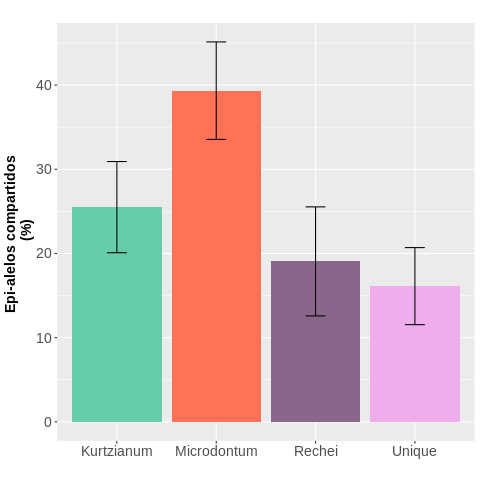

In [ ]:
#@title Gráfico
%%R
p<-ggplot(summaryComparacion,aes(x=Especies,y=mean, fill=Especies))+ geom_bar(stat="identity", position=position_dodge(), show.legend = F) +
geom_errorbar(aes(ymin=mean-sd, ymax=mean+sd), width=.2, position=position_dodge(.9)) +
scale_fill_manual(values=c('aquamarine3', 'coral1', 'plum4', 'plum2')) +
labs(title="", x="", y = "Epi-alelos compartidos \n (%)")+ theme(axis.text=element_text(size=14),
        axis.title=element_text(size=14,face="bold"))
plot(p)
pdf("/content/plots/comparaciónHibridos.pdf")
plot(p)
dev.off()

<a name="step-3"></a>
# Guardar en Drive







Opcional. 
Depende del espacio disponible en Drive.
Si desea copiar los datos, debe eliminar el numeral (`#`) de cada línea de código EXCEPTO la primera ``#@title``

In [ ]:
#@title Guardar archivos en el Drive personal
%%bash
#mkdir ../drive/MyDrive/EpiEvo/TP_1
#cd ..
#echo 'Usted está en:'
#pwd
#echo 'Lista de archivos en colab:'
#ls
#cp -r {plots,rawData,results} drive/MyDrive/EpiEvo/TP_1/
#echo 'Lista de archivos en TP_1 en su drive:'
#ls drive/MyDrive/EpiEvo/TP_1/